In [1]:
import xarray as xr 
import numpy as np
import math 
import glob
import s3fs 
import warnings 
import matplotlib.pyplot as plt
import zarr

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path2 = 's3://data/vel_dataIII.zarr/vel_dataIII.zarr'
data_path3 = 's3://data/lat_lon_scalar.zarr'
remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)

store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)

dv = xr.open_zarr(store=store2, consolidated=True)
dl = xr.open_zarr(store=store3, consolidated=True)

In [3]:
zonal = dl.d_zonal
merd = dl.d_merd

In [4]:
dv

<xarray.Dataset>
Dimensions:        (depth: 75, t: 1, time_counter: 73, x: 1200, y: 900)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    time_centered  (time_counter) object dask.array<chunksize=(73,), meta=np.ndarray>
  * time_counter   (time_counter) object 2000-01-03 12:00:00 ... 2000-12-29 1...
Dimensions without coordinates: t, x, y
Data variables:
    mbathy         (t, y, x) int16 dask.array<chunksize=(1, 900, 1200), meta=np.ndarray>
    vel            (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
    vomecrty       (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
    vozocrtx       (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean (interval: 360 s)
    interval_operation:  360 s
    interval_write:      5 d
    long_name:           sea_water_x_velocity
    online_operation:    average
    standard_name:       sea_water_x_velocity
    units:               m/s

In [5]:
d = dv.mbathy
u = dv.vozocrtx
v = dv.vomecrty
vel = np.sqrt(u**2 + v**2)

In [7]:
d_hbx = d.isel(y=slice(0,899)).diff(dim='x')
d_hbx = d_hbx.squeeze(axis=0)
d_hby = d.isel(x=slice(0,1199)).diff(dim='y')
d_hby = d_hby.squeeze(axis=0)

len_bat = np.sqrt((d_hbx/zonal)**2 + (d_hby/merd)**2)

503 502
638 300
871 602
820 200
520 350


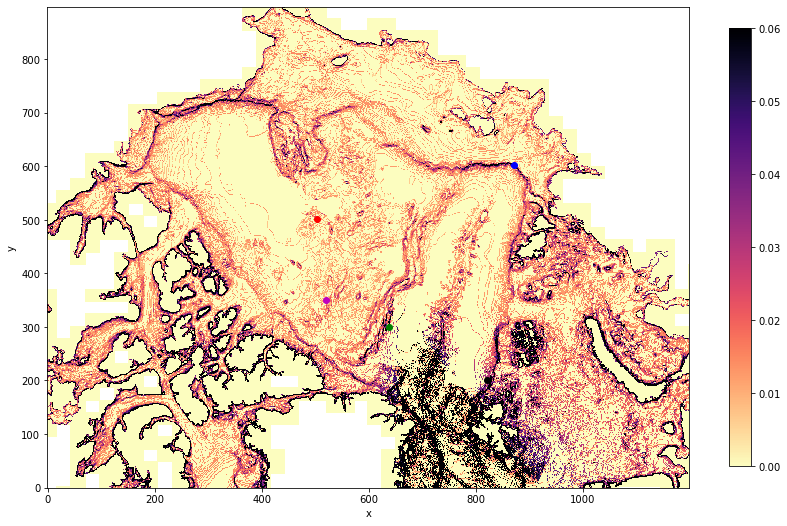

In [8]:
warnings.simplefilter("ignore")
punkt_list = [(503,502), (638,300), (871,602), (820,200), (520,350)]

fig, axs = plt.subplots(1,1,figsize=(12,9))
c_list = ['r', 'g', 'b', 'k', 'm']

cmap = plt.get_cmap('magma_r')
c = len_bat.plot(vmin=0, vmax=0.06, cmap=cmap, add_colorbar=False)
for p in range(len((punkt_list))):
    pp = punkt_list[p]
    print(pp[0], pp[1]) 
    axs.plot(pp[0],pp[1] ,marker = 'o' ,color = c_list[p])
    
fig.colorbar(c,
             shrink=0.7,
             #label=r"Depth [m]"
            )
axs.set_aspect('equal')
fig.tight_layout()

503 502
638 300
871 602
820 200
520 350


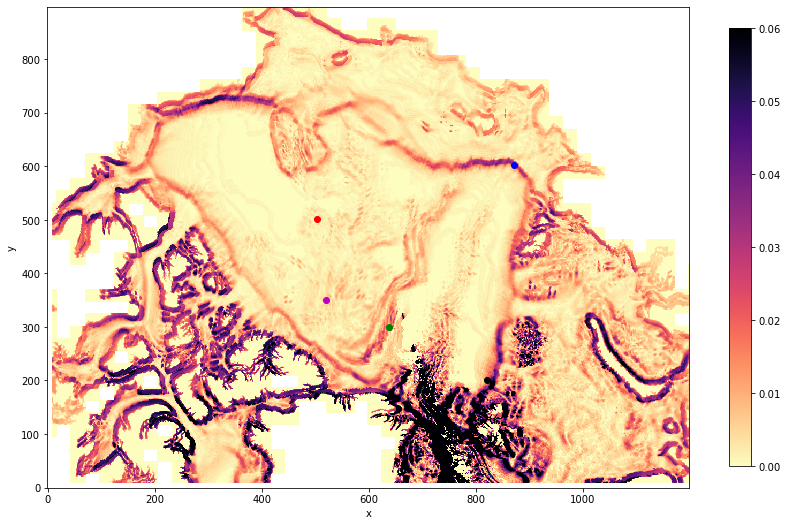

In [9]:
'Glatte bathymetrien først'
warnings.simplefilter("ignore")

d_hbxg = d_hbx.rolling(x= 10,).mean()
d_hbyg = d_hby.rolling(y= 10,).mean()

len_batg = np.sqrt((d_hbxg/zonal)**2 + (d_hbyg/merd)**2)

punkt_list = [(503,502), (638,300), (871,602), (820,200), (520,350)]

fig, axs = plt.subplots(1,1,figsize=(12,9))
c_list = ['r', 'g', 'b', 'k', 'm']

cmap = plt.get_cmap('magma_r')
c = len_batg.plot(vmin=0, vmax=0.06, cmap=cmap, add_colorbar=False)
for p in range(len((punkt_list))):
    pp = punkt_list[p]
    print(pp[0], pp[1]) 
    axs.plot(pp[0],pp[1] ,marker = 'o' ,color = c_list[p])
fig.colorbar(c,
             shrink=0.7,
             #label=r"Depth [m]"
            )    
axs.set_aspect('equal')
fig.tight_layout()

'zoomed in to see resolutin'
punkt_list = [(53,52), (38,50), (71,52), (820,200), (520,350)]

fig, axs = plt.subplots(1,1,figsize=(20,15))

cmap = plt.get_cmap('magma_r')
c = len_bat.isel(x=slice(450,550),y=slice(450,550)).plot(vmin=0, vmax=0.06, cmap=cmap)

pp = punkt_list[0]
print(pp[0], pp[1]) 
axs.plot(pp[0],pp[1] ,marker = 'o' ,color = 'b')
axs.set_aspect('equal')

In [10]:
for p in punkt_list:
    pp = p
    y=pp[1]
    x=pp[0]
    print(pp[0], pp[1])
    d_hbx_p = d_hbx.isel(y=y, x=x)
    d_hby_p = d_hby.isel(y=y, x=x)
    zonalp = zonal.isel(x=x,y=y)
    merdp = merd.isel(x=x, y=y)
    print('-------------------')
    print((d_hbx_p/zonalp).values, (d_hby_p/merdp).values)
    print('new point')

503 502
-------------------
-0.0 0.012180641
new point
638 300
-------------------
-0.023390058 -0.011324999
new point
871 602
-------------------
-0.031962655 -0.038862083
new point
820 200
-------------------
-0.032732025 0.0
new point
520 350
-------------------
0.009189493 0.0
new point


In [11]:
'Making a function for the vertical PC'
def PCz(x,y):
    up = u.isel(y=y, x=x)
    vp = v.isel(y=y, x=x)

    zonalp = zonal.isel(y=y, x=x)
    merdp = merd.isel(y=y, x=x)

    d_hbx_p = d_hbxg.isel(y=y, x=x)
    d_hby_p = d_hbyg.isel(y=y, x=x)
    
    # lag lengde scalar av bathym og dele u_o og u_p på 

    vel_ort = (up*(d_hbx_p/zonalp) + vp*(d_hby_p/merdp))/np.sqrt(d_hbx_p**2 + d_hby_p**2) # delt på lengden av bathymetrien
    vel_par = (up*(d_hby_p/merdp)  - vp*(d_hbx_p/zonalp))/np.sqrt(d_hbx_p**2 + d_hby_p**2)
    
    d_p = d.isel(y=y, x=x).values
    dyp_o = vel_ort.isel(depth = slice(12,int(d_p)-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    dyp_p = vel_par.isel(depth = slice(12,int(d_p)-1))

    cov_o = np.cov(dyp_o.T, bias=True) # uten .T ble den en 73x73 matrise 
    cov_p = np.cov(dyp_p.T, bias=True)
    
    values_o, vectors_o = np.linalg.eig(cov_o)
    order_o = values_o.argsort()[::-1]
    values_o, vectors_o = values_o[order_o], vectors_o[:, order_o]
    values_p, vectors_p = np.linalg.eig(cov_p)
    order_p = values_p.argsort()[::-1]
    values_p, vectors_p = values_p[order_p], vectors_p[:, order_p]
    
    PCp = np.sqrt(values_p[0])*vectors_p[:,0]
    PCo = np.sqrt(values_o[0])*vectors_o[:,0]
    
    return PCp, PCo, dyp_p, dyp_o

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (18,7))
plt.suptitle('PC1 from velocity parallell and ortoghonal to the slope calculated from model-data at different location; see map ', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    PCp, PCo, dypp, dypo = PCz(pp[0],pp[1])
        
    axs.plot(PCp,dypp.depth, 'g', label = 'The velocity parallel to the slope')
    axs.plot(PCo,dypo.depth, 'r', label = 'The velocity orthogonal to the slope')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=14, loc="upper left") 
    axs.invert_yaxis()
    axs.set_xlabel('Variance in current speed [cm^2/m^2]', fontsize=14)
fig.tight_layout()

503 502


# Feilsøking

In [12]:
np.isnan(np.array(grad_hb)).any()

/opt/conda/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


True

In [13]:
np.isnan(np.array(grad_hb[500,500])).any()

/opt/conda/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


False

# Tester for punkt

In [14]:
x=820
y=200

u = du.vozocrtx.isel(y=y, x=x)
v = dv.vomecrty.isel(y=y, x=x)
print(u.shape, v.shape)

d_zonal = dm.glamu.isel(y=y, x=x).squeeze(axis=0)
d_merd = dm.gphiu.isel(y=y, x=x).squeeze(axis=0)

d_hbx_p = d_hbx.isel(y=y, x=x)
d_hby_p = d_hby.isel(y=y, x=x)


vel_ort = u*(d_hbx_p/d_zonal) + v*(d_hby_p/d_merd) 
vel_par = u*(d_hby_p/d_merd)  - v*(d_hbx_p/d_zonal) 

(73, 75) (73, 75)


In [15]:
vel_ort.shape

(73, 75)

In [17]:
d = ds.mbathy.isel(y=y, x=x).values
dyp = vel_ort.isel(depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter

cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 

In [18]:
print(cov.shape)
print(np.isnan(cov).any())
    
values_o, vectors_o = np.linalg.eig(cov)
order = values_o.argsort()[::-1]
values_o, vectors_o = values_o[order], vectors_o[:, order]

(60, 60)
False


# Velocity ortogonal to the slope 

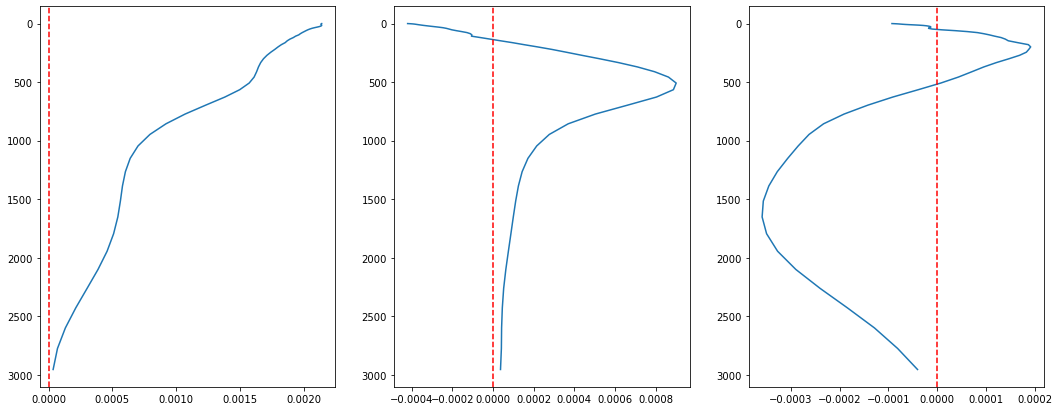

In [20]:
fig, (axs1,axs2,axs3) = plt.subplots(1,3,figsize = (18,7))
axs1.plot(np.sqrt(values_o[0])*vectors_o[:,0], dyp.depth)
axs2.plot(np.sqrt(values_o[1])*vectors_o[:,1], dyp.depth)
axs3.plot(np.sqrt(values_o[2])*vectors_o[:,2], dyp.depth)

axs1.axvline(0, color='r', linestyle = '--')
axs1.invert_yaxis()
axs2.axvline(0, color='r', linestyle = '--')
axs2.invert_yaxis()
axs3.axvline(0, color='r', linestyle = '--')
axs3.invert_yaxis()

# Velocity parallell to the slope 

In [27]:
d = ds.mbathy.isel(y=y, x=x).values
dyp = vel_par.isel(depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter

cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 

In [28]:
print(cov.shape)
print(np.isnan(cov).any())
    
values_p, vectors_p = np.linalg.eig(cov)
order = values_p.argsort()[::-1]
values_p, vectors_p = values_p[order], vectors_p[:, order]

(60, 60)
False


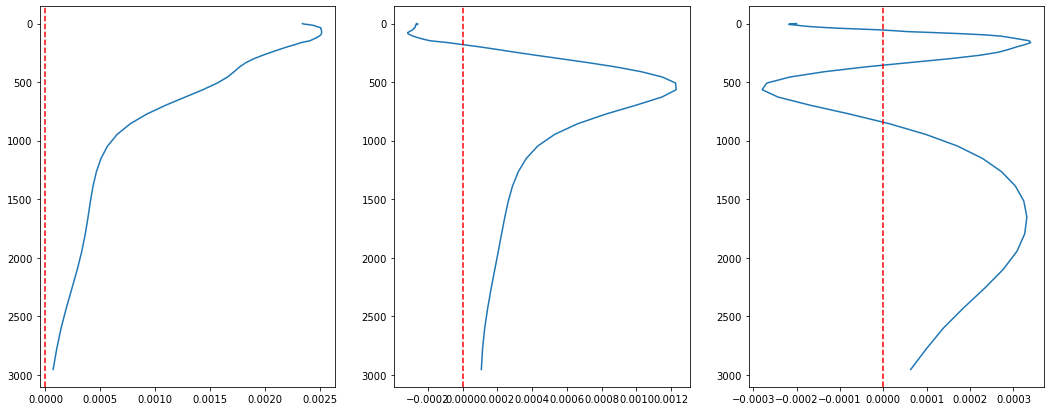

In [29]:
fig, (axs1,axs2,axs3) = plt.subplots(1,3,figsize = (18,7))
axs1.plot(np.sqrt(values_p[0])*vectors_p[:,0], dyp.depth)
axs2.plot(np.sqrt(values_p[1])*vectors_p[:,1], dyp.depth)
axs3.plot(np.sqrt(values_p[2])*vectors_p[:,2], dyp.depth)

axs1.axvline(0, color='r', linestyle = '--')
axs1.invert_yaxis()
axs2.axvline(0, color='r', linestyle = '--')
axs2.invert_yaxis()
axs3.axvline(0, color='r', linestyle = '--')
axs3.invert_yaxis()

## Med både ort og par

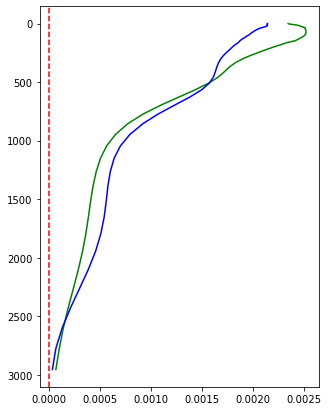

In [31]:
fig, axs = plt.subplots(1,1,figsize = (5,7))
axs.plot(np.sqrt(values_p[0])*vectors_p[:,0], dyp.depth, color='g')
axs.plot(np.sqrt(values_o[0])*vectors_o[:,0], dyp.depth, color='b')

axs.axvline(0, color='r', linestyle = '--')
axs.invert_yaxis()

 OK, funker for et punkt, men ser ikke ut sånn som forventet.. minor burde vært mye mindre og gått mye fortere mot null siden vi forventet liten hastighet på tvers av topografien .. 
 
 prøver med punkt listen 

In [66]:
x = 870
y = 600

u = du.vozocrtx.isel(y=y, x=x)
v = dv.vomecrty.isel(y=y, x=x)
print(u.shape, v.shape)

d_zonal = dm.glamu.isel(y=y, x=x).squeeze(axis=0)
d_merd = dm.gphiu.isel(y=y, x=x).squeeze(axis=0)

d_hbx_p = d_hbx.isel(y=y, x=x)
d_hby_p = d_hby.isel(y=y, x=x)


vel_ort = u*(d_hbx_p/d_zonal) + v*(d_hby_p/d_merd) 
vel_par = u*(d_hby_p/d_merd)  - v*(d_hbx_p/d_zonal) 


(73, 75) (73, 75)


In [59]:
vel_ort

<xarray.DataArray (time_counter: 73, depth: 75)>
dask.array<add, shape=(73, 75), dtype=float32, chunksize=(1, 75), chunktype=numpy.ndarray>
Coordinates:
  * depth         (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) object 2000-01-03 12:00:00 ... 2000-12-29 12...

In [67]:
d = ds.mbathy.isel(y=y, x=x).values
dyp_o = vel_ort.isel(depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
dyp_p = vel_par.isel(depth = slice(0,d-1))

cov_o = np.cov(dyp_o.T, bias=True) # uten .T ble den en 73x73 matrise 
cov_p = np.cov(dyp_p.T, bias=True)

In [53]:
print('any nan in cov_p: ', np.isnan(cov_p).any())
print('any nan in cov_o: ', np.isnan(cov_o).any())

    
values_o, vectors_o = np.linalg.eig(cov_o)
order = values_o.argsort()[::-1]
values_o, vectors_o = values_o[order], vectors_o[:, order]

values_p, vectors_p = np.linalg.eig(cov_p)
order = values_p.argsort()[::-1]
values_p, vectors_p = values_p[order], vectors_p[:, order]

any nan in cov_p:  False
any nan in cov_o:  False


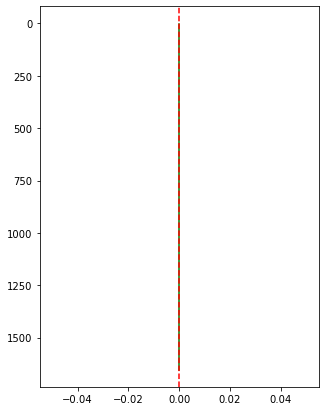

In [56]:
fig, axs = plt.subplots(1,1,figsize = (5,7))
axs.plot(np.sqrt(values_p[0])*vectors_p[:,0], dyp_p.depth, color='g')
axs.plot(np.sqrt(values_o[0])*vectors_o[:,0], dyp_o.depth, color='b')

axs.axvline(0, color='r', linestyle = '--')
axs.invert_yaxis()

# forsøk med punktliste 

### U_ortogonal & U_parallell

In [56]:
u = du.vozocrtx.isel(y=slice(900,1799), x=slice(200,1399))
v = dv.vomecrty.isel(y=slice(900,1799), x=slice(200,1399))
print(u.shape, v.shape)

(73, 75, 899, 1199) (73, 75, 899, 1199)


In [57]:
vel_ort = u*(d_zonal/delta_dx) + v*(d_merd/delta_dy)
#vel_ort = np.nan_to_num(vel_ort) --> denne får ting til å kræsje 
vel_par = u*(d_merd/delta_dy) - v*(d_zonal/delta_dx)
#vel_par = np.nan_to_num(vel_par) også får ting til å kræsje 

In [17]:
a = xr.ufuncs.isfinite(vel_ort).any()
print(a)

<xarray.DataArray ()>
dask.array<any-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>


In [21]:
print(vel_ort.shape)
vel_ort[0,0,:,0].shape

(73, 75, 899, 1199)


(899,)

### Visulizing 

In [59]:
punkt_list = [(500,500), (650,300), (870,600), (820,200), (520,350)]

500 500
650 300
870 600
820 200
520 350


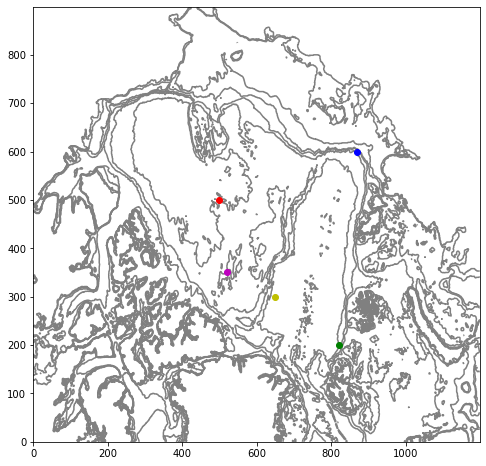

In [60]:
fig, axs = plt.subplots(1,1,figsize=(8,8))
c_list = ['r', 'y', 'b', 'g', 'm']
axs.contour(d, colors = 'grey')

for p in range(len((punkt_list))):
    
    pp = punkt_list[p]
    print(pp[0], pp[1]) 
    axs.plot(pp[0],pp[1] ,marker = 'o' ,color = c_list[p])

Ortogonal 

In [61]:
def PCz(x,y):
    'Finding the level the given location dosent have values for anymore'
    
    d = ds.mbathy.isel(y=y, x=x).values
    dyp = vel_ort.isel(x=x, y=y, depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    
    if np.isnan(covm).any():
            continue
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

500 500


LinAlgError: Array must not contain infs or NaNs

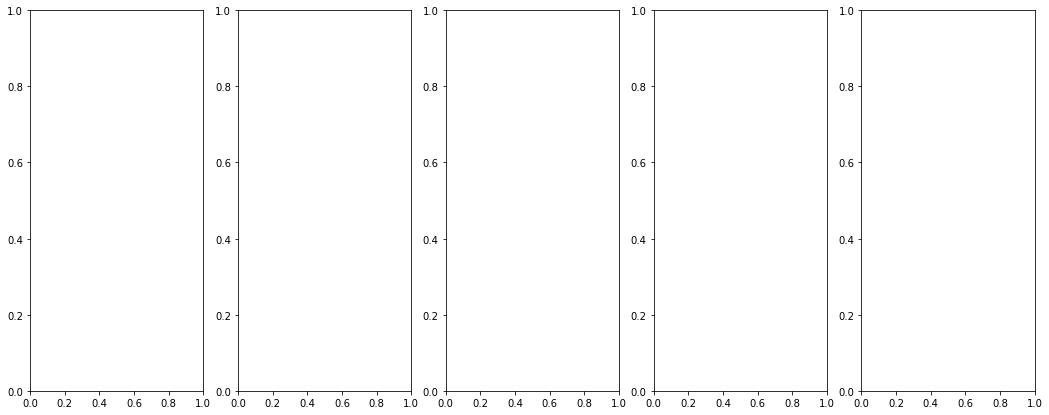

In [62]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (18,7))

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()

Parallell 

In [ ]:
def PCz(x,y):
    'Finding the level the given location dosent have values for anymore'
    
    d = ds.mbathy.isel(y=y, x=x).values
    dyp = vel_par.isel(x=x, y=y, depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (18,7))
ax.set_title('Vel_parallell')

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()

## 20 m down 

In [69]:
def PCz_20(x,y):
    'Finding the level the given location dosent have values for anymore'
    
    d = ds.mbathy.isel(y=y, x=x).values
    dyp = vel_ort.isel(x=x, y=y, depth = slice(15,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

500 500


KeyboardInterrupt: 

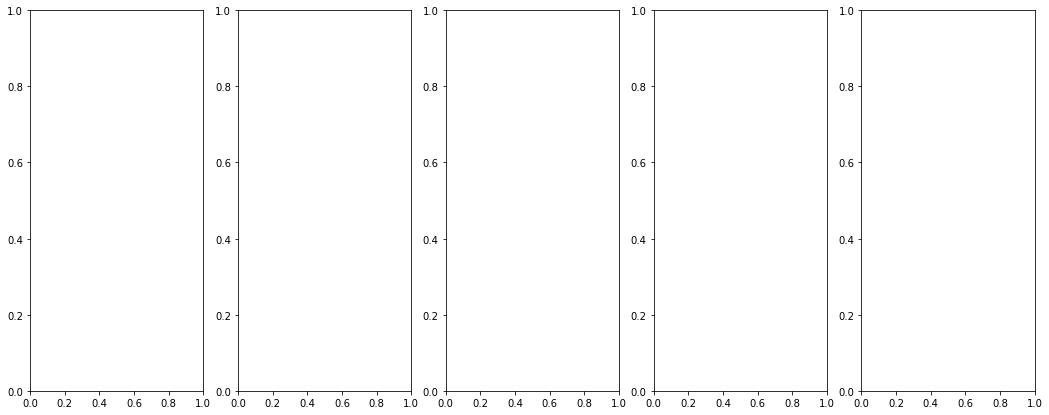

In [70]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (18,7))
ax.set_title('Vel_ortogonal, without the first 20m')

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz_20(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth+22, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth+22, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth+22, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()

In [ ]:
def PCz_20(x,y):
    'Finding the level the given location dosent have values for anymore'
    
    d = ds.mbathy.isel(y=y, x=x).values
    dyp = vel_par.isel(x=x, y=y, depth = slice(15,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,5,figsize = (18,7))
ax.set_title('Vel_parallell, without the first 20m')

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz_20(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth+22, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth+22, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth+22, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()